# Demo on the "most common" regridder

For regridding categorical data to a coarser resolution, normal regridding methods don't work.
This can be data like land cover or vegetation type.

For this reason we implemented a "most common" regridder, which takes the most common value of the source data cells that overlap with the target grid cells.

If you want to regrid data to a finer resolution, the "nearest-neighbor" regridder can be used.

We start with importing the required packages:

In [1]:
import xarray as xr
import xarray_regrid

import dask.distributed

client = dask.distributed.Client()

Next twe need a high resolution dataset to regrid. We used the LCCS land cover data which is available from the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover).

We will also define our target grid:

In [2]:
ds = xr.open_dataset(
    "../ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7cds.nc",
    chunks={"lat": 2000, "lon": 2000},
)

ds = ds[["lccs_class"]]  # Only take the class variable.
ds = ds.sortby(["lat", "lon"])
ds = ds.rename({"lat": "latitude", "lon": "longitude"})

from xarray_regrid import Grid, create_regridding_dataset

new_grid = Grid(
    north=90,
    east=90,
    south=0,
    west=0,
    resolution_lat=1,
    resolution_lon=1,
)
target_dataset = create_regridding_dataset(new_grid)

Using `regrid.most_common` you can regrid the data.

Currently the computation can not be done fully lazily, however a workaround that splits the problem into chunks and combines the solution is available. This is enabled using the "max_mem" keyword argument.

Note that the maximum memory limits the size of the regridding routine (in bytes), not of the input/output data, so total memory use can be higher.

In [3]:
ds_regrid = ds.regrid.most_common(target_dataset, time_dim="time", max_mem=1e9)

After computation, we can plot the solution:

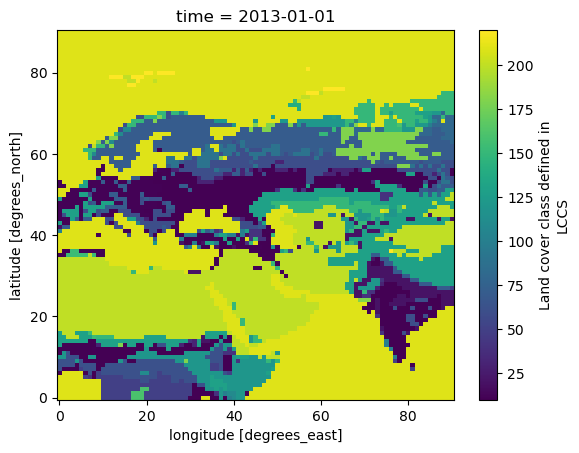

In [4]:
ds_regrid["lccs_class"].plot(x="longitude")